# Analytics For Unstructured Data: Group Assignment #1

In [ ]:
# install if necessary
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
# import necessary libraries for everything
# System and path setup
import sys
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')  # Ensure Python can find ChromeDriver

# Web scraping libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains

# Time utilities
import time

# Data manipulation and file handling
import pandas as pd
import numpy as np
import csv
import shutil
from tempfile import NamedTemporaryFile
import io

# Natural language processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from collections import Counter, defaultdict
import re
import string

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and text processing
from sklearn import manifold
from sklearn.feature_extraction.text import CountVectorizer

# Additional utilities
import itertools
from itertools import combinations
import decimal
import operator

## Scraper
https://realpython.com/modern-web-automation-with-python-and-selenium/ 

In [32]:
#WebDriver is a browser automation framework that works with open source APIs.
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

zsh:1: command not found: apt-get
The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

cp: /usr/lib/chromium-browser/chromedriver: No such file or directory


In [2]:
driver = webdriver.Chrome(options=chrome_options)

# Create DataFrame
comments = pd.DataFrame(columns = ['Date','user_id','comments'])


#Srape Dates, Usernames, and Comments from most recent 115 pages (about 5000 comments)
for i in range(320,436):

    #address where scraping
    webpage = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p' + str(i)
    driver.get(webpage)

    ids = driver.find_elements(By.XPATH,"//*[contains(@id,'Comment_')]")

    comment_ids = []

    for i in ids:
        comment_ids.append(i.get_attribute('id'))

    #check if there is a blockquote (used in replies to comments) and remove
    for x in comment_ids:
        try:
            element = driver.find_elements(By.XPATH,'//*[@id="' + x +'"]/div/div[3]/div/div[1]/blockquote')[0]
            driver.execute_script("""
                var element = arguments[0];
                element.parentNode.removeChild(element);
                """, element)
        except:
            pass

    for x in comment_ids:

        #Extract dates from for each user on a page
        user_date = driver.find_elements(By.XPATH,'//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
        date = user_date.get_attribute('title')

        #Extract user ids from each user on a page
        userid_element = driver.find_elements(By.XPATH,'//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
        userid = userid_element.text

        #Extract Message for each user on a page
        user_message = driver.find_elements(By.XPATH,'//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]

        comment = user_message.text


        #Adding date, userid and comment for each user in a dataframe
        comments.loc[len(comments)] = [date,userid,comment]

In [ ]:
#Nulls don't play well with the tokenizer, so drop nulls
comments.dropna(inplace=True)

#change the location as per the file destination you want it to be
comments.to_csv('data/Edmunds_scraped2.0.csv', index=False)

In [28]:
#If working from CSV instead of scraping originally, read in CSV
comments = pd.read_csv('data/Edmunds_scraped2.0.csv')

## Task A: Zipf's Law

In [11]:
# raw word frequencies
# Download stopwords from the NLTK package
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Input and output filenames
input_filename = 'data/Edmunds_scraped2.0.csv'  # Input file
final_filename = 'data/final.csv'  # Intermediate file without the column header
word_freq_output = 'data/word_freq.csv'  # Output file for word frequencies

# Function to clean and tokenize sentences
def clean_and_tokenize(sentence):
    """
    Cleans a given sentence by removing punctuation, converting text to lowercase,
    and tokenizing the remaining words.
    """
    # Remove punctuation and convert text to lowercase
    sentence = re.sub(f'[{re.escape(string.punctuation)}]', '', sentence.lower())

    # Tokenize and remove stopwords
    return [word for word in sentence.split()]

# Step 1: Remove header from the input CSV and create a new file without it
def remove_header(input_file, output_file):
    """
    Reads the input CSV file, removes the header, and writes the remaining rows
    into a new output file.
    """
    file = pd.read_csv(input_file, header = None, skiprows = 1)
    file.to_csv(output_file, index = False)

# Step 2: Extract and clean sentences from the text
def extract_sentences(file):
    """
    Extracts text data from the third column of the CSV file, splits it into sentences,
    and cleans each sentence by removing punctuation and stopwords.
    """
    df = pd.read_csv(file, header = None)
    posts = df.iloc[:,2]
    sentences = []
    sentences_clean = []
    for post in posts:
        sentences.extend(re.split('[?.!]', post))
    for sentence in sentences:
        cleaned_tokens = clean_and_tokenize(sentence)
        if cleaned_tokens:
            sentences_clean.append(cleaned_tokens)
    return sentences_clean


# Step 3: Calculate word frequencies
def calculate_word_frequencies(sentences):
    """
    Calculates the frequency of each word in the given list of cleaned sentences.
    """
    freqs = {}
    total_words = 0
    for sentence in sentences:
        for word in sentence:
            freqs[word] = freqs.get(word, 0) + 1
            total_words += 1
    return freqs

# Step 4: Write word frequencies to CSV
def write_word_frequencies(word_freq, output_file):
    """
    Writes the word frequencies to the specified CSV file.
    """
    word_freq_df = pd.DataFrame(word_freq.items(), columns = ["Word", "Frequency"])
    word_freq_df = word_freq_df.sort_values(by = "Frequency", ascending = False)
    word_freq_df.to_csv(output_file, index=False)
    print(f"Word frequencies written to {output_file}")

# Main function to run all steps
def main():
    # Step 1: Remove header
    remove_header(input_filename, final_filename)
    
    # Step 2: Extract and clean sentences
    sentences = extract_sentences(final_filename)
    
    # Step 3: Calculate word frequencies
    word_freq = calculate_word_frequencies(sentences)
    
    # Step 4: Write word frequencies to CSV
    write_word_frequencies(word_freq, word_freq_output)

if __name__ == "__main__":
    main()


[nltk_data] Downloading package stopwords to /Users/kenne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Word frequencies written to data/word_freq.csv


Text(0.5, 1.0, 'Frequency vs. Rank for Top 100 Words in Edmunds Forum')

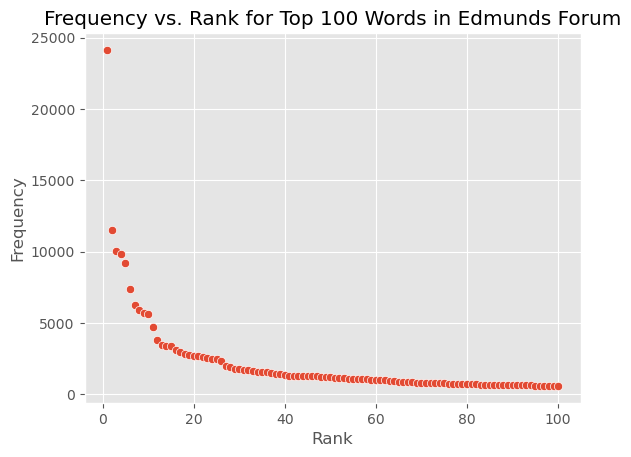

In [248]:
df = pd.read_csv('data/word_freq.csv')
df["rank"] = range(len(df))
df["rank"] += 1

X = df["rank"][:100]
y = df["Frequency"][:100]


sns.scatterplot(x = X, y = y)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Frequency vs. Rank for Top 100 Words in Edmunds Forum")

# this is the plot just for the top 100 frequencies as is, no log

Text(0.5, 1.0, 'Log Frequency vs. Rank for Top 100 Words in Edmunds Forum')

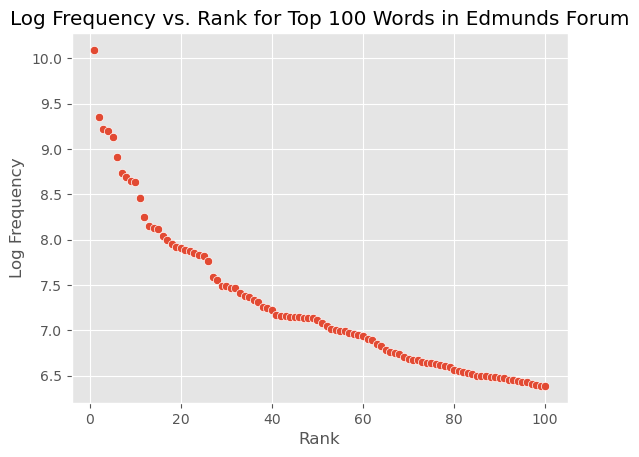

In [249]:
y_log = np.log(y)

sns.scatterplot(x = X, y = y_log)
plt.xlabel("Rank")
plt.ylabel("Log Frequency")
plt.title("Log Frequency vs. Rank for Top 100 Words in Edmunds Forum")

In [30]:
# test Zipf's law economometrically
df["theta"] = np.log(df["rank"]) / np.log(df["Frequency"] / len(df))
print("The average value of theta is: " + str(np.mean(df["theta"])))

The average value of theta is: -1.008228725373608


In [267]:
# Regression to test econometrically
y = np.log(df["rank"])
X = np.log(df["Frequency"] / len(df))

import statsmodels.api as sm
# Fit the model without an intercept
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                   rank   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.074e+07
Date:                Sun, 15 Sep 2024   Prob (F-statistic):                        0.00
Time:                        00:01:47   Log-Likelihood:                         -10276.
No. Observations:               20843   AIC:                                  2.055e+04
Df Residuals:                   20842   BIC:                                  2.056e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [271]:
# Get coefficient for the variable of interest
coef = model.params.iloc[0]
std_err = model.bse.iloc[0]

# Hypothesized value (the value you want to test against)
hypothesized_value = -1

# Calculate t-statistic
t_stat = (coef - hypothesized_value) / std_err

# Calculate p-value from the t-statistic
from scipy import stats

# Degrees of freedom
df = model.df_resid

# Calculate two-tailed p-value
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=df))

print(f"Coefficient: {coef}")
print(f"Standard Error: {std_err}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("The coefficient is significantly different from -1.")
else:
    print("The coefficient is not significantly different from -1.")

Coefficient: -0.9930218397053721
Standard Error: 0.00030304796561199816
T-statistic: 23.02658683266761
P-value: 0.0
The coefficient is significantly different from -1.


**Zipf's law is not supported because $\theta$ is significantly different from -1 (p < .001).**

## Task B: Frequencies

### Find and Replace
**Edit the "car_models_and_brands.csv" to include aspirational bigrams and trigrams that we want to replace with "aspiration" later on.**

In [ ]:
# Filepaths
output_file = 'data/replacement_sample_data.csv'  # The file where the modified data will be stored 
input_file = 'data/sample_data.csv'               # The file containing the original data
replacement_file = 'data/car_models_and_brands.csv'   # The file containing original and replacement words

# Create a temporary file to write the changes before moving it to the final location
tempfile = NamedTemporaryFile(mode='w', delete=False, newline='', encoding='utf-8')

def load_replacements(replacement_file):
    """
    Load word replacements from a CSV file into a dictionary.
    The right column contains words to be replaced by the corresponding words in the left column.
    """
    replacements = {}
    with open(replacement_file, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in reader:
            original, replacement = row[1].lower(), row[0].lower()  # Ensure lowercase comparison
            replacements[original] = replacement
    return replacements

def replace_words_in_text(text, replacements):
    """
    Replace words or phrases (including bi-grams and tri-grams) in the input text according to the replacements dictionary.
    """
    # Sort replacements by length (so tri-grams are checked before bi-grams, etc.)
    sorted_replacements = sorted(replacements.keys(), key=lambda x: len(x.split()), reverse=True)
    
    # Create a pattern to match any n-grams (bi-grams, tri-grams, etc.)
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in sorted_replacements) + r')\b', re.IGNORECASE)
    
    # Function to preserve the original case of the replacement
    def replacement_func(match):
        original_word = match.group(0).lower()
        return replacements.get(original_word, original_word)
    
    # Replace matched phrases in the text using the generated pattern
    return pattern.sub(replacement_func, text)

def process_file(input_file, output_file, replacements):
    """
    Read the input file, perform word replacements, and write the modified content to the output file.
    """
    # Open input and temporary output files
    with open(input_file, 'r', encoding='utf-8') as infile, tempfile:
        reader = csv.reader(infile, delimiter=',', quotechar='"')
        writer = csv.writer(tempfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
        # Write the header if present
        header = next(reader)
        writer.writerow(header)
        
        for row in reader:
            new_row = [replace_words_in_text(cell, replacements) for cell in row]
            writer.writerow(new_row)

    # Replace the original file with the modified file
    shutil.move(tempfile.name, output_file)

def main():
    # Load the replacement words from the replacement CSV file
    replacements = load_replacements(replacement_file)

    # Process the input file and apply the replacements
    process_file(input_file, output_file, replacements)

if __name__ == "__main__":
    main()


**Use replacement_sample_data.csv from now on!**

### Frequency Counts
We count the post word frequency now instead of total word frequency

In [8]:
# Download stopwords from the NLTK package
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Input and output filenames
input_filename = 'data/replacement_sample_data.csv'  # Input file
word_freq_output = 'data/word_post_count.csv'  # Output file for word post count

# Function to clean text (removing punctuation and stopwords)
def clean_text(post):
    """
    Cleans a given post by removing punctuation and stopwords, and converting text to lowercase.
    """
    post = re.sub(f'[{re.escape(string.punctuation)}]', '', post.lower())  # Remove punctuation and convert to lowercase
    words = post.split()  # Tokenize the post
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Step 1: Clean the posts from the CSV
def clean_posts(input_file):
    """
    Reads the input CSV file, cleans the posts, and returns a list of cleaned posts.
    """
    df = pd.read_csv(input_file, header=None)  # Load CSV
    posts = df.iloc[:, 2]  # Extract the third column (posts)
    cleaned_posts = posts.apply(clean_text)  # Apply cleaning to each post
    return cleaned_posts

# Step 2: Use CountVectorizer to count how many posts each word appears in
def count_word_occurrences(posts):
    """
    Uses CountVectorizer to count how many posts each word appears in.
    """
    vectorizer = CountVectorizer(binary=True)  # binary=True to count post occurrences (not word frequency)
    X = vectorizer.fit_transform(posts)  # Transform the posts into a document-term matrix
    word_counts = X.toarray().sum(axis=0)  # Sum the binary values to get the number of posts each word appears in
    words = vectorizer.get_feature_names_out()  # Get the words from the vocabulary
    word_post_count = dict(zip(words, word_counts))  # Map words to their post counts
    return word_post_count

# Step 3: Write the word counts to a CSV file
def write_word_counts_to_csv(word_post_count, output_file):
    """
    Writes the word-post-counts to the specified CSV file.
    """
    word_post_count_df = pd.DataFrame(list(word_post_count.items()), columns=["Word", "Post_Count"])
    word_post_count_df = word_post_count_df.sort_values(by="Post_Count", ascending=False)
    word_post_count_df.to_csv(output_file, index=False)
    print(f"Word post counts written to {output_file}")

# Main function to run all steps
def main():
    # Step 1: Clean posts
    cleaned_posts = clean_posts(input_filename)
    
    # Step 2: Count how many posts each word appears in
    word_post_count = count_word_occurrences(cleaned_posts)
    
    # Step 3: Write word post counts to CSV
    write_word_counts_to_csv(word_post_count, word_freq_output)

if __name__ == "__main__":
    main()

[nltk_data] Downloading package stopwords to /Users/kenne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Word post counts written to data/word_post_count.csv


In [36]:
freqs = pd.read_csv('data/word_post_count.csv')
freqs.head(60)

,Word,Post_Count
0,car,2802
1,bmw,1925
2,hyundai,1790
3,kia,1709
4,toyota,1671
5,like,1511
6,one,1354
7,would,1249
8,get,1236
9,dont,1181


The top 10 brands according to the post frequencies above are:
1. BMW
2. Hyundai
3. Kia
4. Toyota
5. Acura
6. Audi
7. Honda
8. Pontiac
9. Lexus
10. Infiniti

## Task C: Lift Calculation

In [239]:
# Initialize global variables and data structures
df_lift = pd.DataFrame(columns=['word1', 'word2', 'lift_value'])  # To store lift values
word_frequency = {}  # Dictionary to store word frequency in posts
word_pair_frequency = defaultdict(dict)  # Dictionary to store word pair co-occurrence frequency
results_dict = {}  # Dictionary to store results with lift values for word pairs
file_length = 0  # Number of rows in the input file
itr = 0  # Row iterator for the lift DataFrame

# File paths
input_file = 'data/find_and_replace.csv'  # Input data file
pair_keys_file = 'edmunds_pair_keys.txt'  # File containing the words to calculate lift
output_lift_values = 'data/Lift_Values.csv'  # Output file for lift values
output_lift_matrix = 'data/Lift_Matrix.csv'  # Output file for lift matrix

# Load NLTK stopwords
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize text (removes punctuation and stopwords)
def clean_text(text):
    """
    Cleans a given text by removing punctuation, converting it to lowercase,
    and tokenizing it, ignoring any stopwords.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    cleaned_tokens = [word for word in tokens if word not in stop_words]

    return cleaned_tokens

# Step 1: Load the words from the edmunds_pair_keys.txt file and generate all pairs
def load_word_pairs(filename):
    """
    Loads words from a file where words are comma-separated in each row.
    Returns a list of all possible word pairs for each row.
    """
    word_pairs = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Generate all possible word pairs from each row
            pairs = list(combinations(row, 2))
            word_pairs.extend(pairs)

    return word_pairs

# Step 2: Process the input CSV file to extract posts and clean the text
def process_input_file(input_filename):
    """
    Processes the input CSV file to extract and clean posts. Each post is tokenized,
    cleaned of punctuation and stopwords, and stored in a list.
    """
    posts = []
    global file_length
    df = pd.read_csv(input_filename)  # Load the CSV file into a DataFrame

    # Assuming 'comments' is the column that contains the text
    for index, row in df.iterrows():
        cleaned_post = clean_text(row['comments'])  # Clean and tokenize the post
        posts.append(cleaned_post)

    file_length = len(df)  # Get the total number of rows
    return posts

# Step 3: Calculate word frequencies and word pair co-occurrences (distance ≥ 5 words)
def calculate_frequencies(posts):
    """
    Calculates the frequency of individual words and word pairs within the posts.
    Updates the global word_frequency and word_pair_frequency dictionaries.
    Only considers word pairs that are 5 or more words apart.
    """
    global word_frequency, word_pair_frequency

    for post in posts:
        word_positions = {}  # Dictionary to track positions of each word

        # Track word positions
        for idx, word in enumerate(post):
            if word not in word_positions:
                word_positions[word] = []
            word_positions[word].append(idx)

        # Count word frequencies
        unique_words = set(post)  # Track unique words in the post to avoid double counting
        for word in unique_words:
            word_frequency[word] = word_frequency.get(word, 0) + 1

        # Count word pair co-occurrences with distance check
        # for word1 in word_positions:
        #     for word2 in word_positions:
        #         if word1 != word2:
        #             # Check if the words are 5 or more positions apart
        #             for pos1 in word_positions[word1]:
        #                 for pos2 in word_positions[word2]:
        #                     if abs(pos1 - pos2) >= 5:
        #                         word_pair_frequency[word1][word2] = word_pair_frequency[word1].get(word2, 0) + 1


        # Track word pairs that have already been marked as co-occurring in this post
        seen_pairs = set()
        # Count word pair co-occurrences with distance check
        for word1 in word_positions:
            for word2 in word_positions:
                if word1 != word2 and (word1, word2) not in seen_pairs:
                    # Check if the words are 5 or fewer positions apart
                    found_pair = False
                    for pos1 in word_positions[word1]:
                        for pos2 in word_positions[word2]:
                            if abs(pos1 - pos2) <= 5:
                                word_pair_frequency[word1][word2] = word_pair_frequency.get(word1, {}).get(word2, 0) + 1
                                seen_pairs.add((word1, word2))  # Mark this pair as seen
                                found_pair = True
                                break  # No need to check more positions; move to the next pair
                        if found_pair:
                            break  # Stop after finding one valid pair in this post
                            
# Step 4: Calculate the lift between word pairs
def calculate_lift(word_pairs):
    """
    Calculates the lift between word pairs using the formula:
    Lift(word1, word2) = P(word1 AND word2) / (P(word1) * P(word2))
    Lift is written to the lift values CSV and stored in a DataFrame for further processing.
    """
    global itr
    
    for word1, word2 in word_pairs:
        # Get the frequency of word1, word2, and their co-occurrence
        freq_word1 = word_frequency.get(word1, 0)
        freq_word2 = word_frequency.get(word2, 0)
        co_occurrence = word_pair_frequency.get(word1, {}).get(word2, 0)

        # Calculate probabilities
        p_word1 = freq_word1 / file_length if freq_word1 else 0
        p_word2 = freq_word2 / file_length if freq_word2 else 0
        p_word1_and_word2 = co_occurrence / file_length if co_occurrence else 0

        # Avoid division by zero
        if p_word1 > 0 and p_word2 > 0:
            lift_value = p_word1_and_word2 / (p_word1 * p_word2) if (p_word1 * p_word2) > 0 else 0
        else:
            lift_value = 0
        # Store lift value in DataFrame
        df_lift.loc[itr] = [word1, word2, lift_value]
        itr += 1
    return df_lift

# Step 5: Write lift values and matrix to CSV
def save_results(df_lift):
    """
    Writes the calculated lift values to a CSV file and also generates a lift matrix,
    saving it to another CSV.
    """
    # Save lift values DataFrame to CSV
    df_lift.to_csv(output_lift_values, index=False)

    # Generate lift matrix
    # must create duplicate word pairs to create 10x10 matrix
    df_lift2 = pd.DataFrame({'word1':df_lift.word2, 'word2':df_lift.word1, 'lift_value':df_lift.lift_value})
    df_lift = pd.concat([df_lift, df_lift2], ignore_index=True)
    lift_matrix = pd.pivot_table(df_lift, values='lift_value', index='word1', columns='word2', fill_value=0)
    lift_matrix.index.name = ''
    lift_matrix.to_csv(output_lift_matrix)

# Main function to run all steps
def main():
    # Step 1: Load word pairs
    word_pairs = load_word_pairs(pair_keys_file)

    # Step 2: Process the input file to extract posts
    posts = process_input_file(input_file)

    # Step 3: Calculate frequencies
    calculate_frequencies(posts)

    # Step 4: Calculate lift values
    df_lift = calculate_lift(word_pairs)

    # Step 5: Save results
    save_results(df_lift)

# Run the script
if __name__ == "__main__":
    main()

In [240]:
df = pd.read_csv('data/Lift_Matrix.csv', index_col = 0)
# remove upper triangular values for display
mask = np.triu(np.ones(df.shape, dtype=bool))
df_masked = df.where(~mask)
df_masked = df_masked.fillna('')
display(df_masked)

,acura,audi,bmw,honda,hyundai,infiniti,kia,lexus,pontiac,toyota
acura,,,,,,,,,,
audi,0.874365,,,,,,,,,
bmw,0.4273,1.104622,,,,,,,,
honda,1.992032,0.260584,0.172293,,,,,,,
hyundai,0.272136,0.451897,0.55817,0.658371,,,,,,
infiniti,2.49004,1.199723,0.694407,0.317058,0.47934,,,,,
kia,0.088143,0.394064,0.542363,0.959591,6.528362,0.582208,,,,
lexus,1.453645,1.065951,1.104271,0.455878,0.738443,4.030346,1.435063,,,
pontiac,0.0,0.397583,0.0,0.0,1.70765,0.0,0.0,0.0,,
toyota,0.471797,0.267845,0.215042,2.155992,1.581823,0.23084,1.164415,2.133713,0.0,


## Task D: MDS Map
https://www.geeksforgeeks.org/sklearn-multi-dimensional-scaling-mds-python-implementation-from-scratch/

https://github.com/tanyakuznetsova/Multidimensional-Scaling-of-European_Cities/blob/main/Multidimensional_scaling_of_European_Cities.ipynb

In [246]:
# looking at 1/lift before plotting

df = pd.read_csv('data/Lift_Matrix.csv', index_col = 0)
# # replace 0 with NaN
# df.replace(0, np.nan, inplace=True)
# # Replace diagonal with 0
# np.fill_diagonal(df.values, 0)
# invert lift values
df_transformed = df.applymap(lambda x: 1/x if x != 0 else x)
df_transformed

/var/folders/18/y5p3lwcd31j2dw1d0_k3lqsh0000gp/T/ipykernel_5452/1251399544.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_transformed = df.applymap(lambda x: 1/x if x != 0 else x)


,acura,audi,bmw,honda,hyundai,infiniti,kia,lexus,pontiac,toyota
acura,0.000000,1.143687,2.340276,0.502000,3.674640,0.401600,11.345200,0.687926,0.0000,2.119556
audi,1.143687,0.000000,0.905287,3.837529,2.212892,0.833526,2.537657,0.938129,2.5152,3.733500
bmw,2.340276,0.905287,0.000000,5.804071,1.791570,1.440077,1.843783,0.905575,0.0000,4.650250
honda,0.502000,3.837529,5.804071,0.000000,1.518900,3.154000,1.042111,2.193571,0.0000,0.463824
hyundai,3.674640,2.212892,1.791570,1.518900,0.000000,2.086200,0.153178,1.354200,0.5856,0.632182
infiniti,0.401600,0.833526,1.440077,3.154000,2.086200,0.000000,1.717600,0.248118,0.0000,4.332000
kia,11.345200,2.537657,1.843783,1.042111,0.153178,1.717600,0.000000,0.696833,0.0000,0.858800
lexus,0.687926,0.938129,0.905575,2.193571,1.354200,0.248118,0.696833,0.000000,0.0000,0.468667
pontiac,0.000000,2.515200,0.000000,0.000000,0.585600,0.000000,0.000000,0.000000,0.0000,0.000000
toyota,2.119556,3.733500,4.650250,0.463824,0.632182,4.332000,0.858800,0.468667,0.0000,0.000000


**What should I be doing with 0 values? We want the distance between a brand and itself to be 0, but I'm not sure in the case of pontiac.**

/var/folders/18/y5p3lwcd31j2dw1d0_k3lqsh0000gp/T/ipykernel_5452/1350687844.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_transformed = df.applymap(lambda x: 1/x if x != 0 else x)


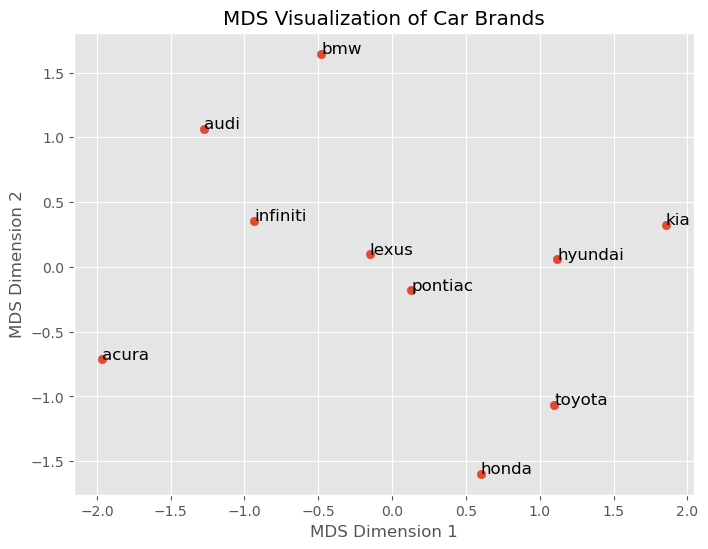

In [242]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.manifold import MDS

df = pd.read_csv('data/Lift_Matrix.csv', index_col = 0)
# # replace 0 with NaN
# df.replace(0, np.nan, inplace=True)
# # Replace diagonal with 0
# np.fill_diagonal(df.values, 0)
# invert lift values
df_transformed = df.applymap(lambda x: 1/x if x != 0 else x)
X = df_transformed

# Create an MDS model with the desired number of dimensions
mds = MDS(n_components=2, dissimilarity = 'precomputed', random_state = 0)
 
# Fit the MDS model to your data
X_reduced = mds.fit_transform(X)
 
# Visualize the reduced data
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
for i, brand in enumerate(df_transformed.columns.values):
    plt.text(X_reduced[i, 0], X_reduced[i, 1], brand, fontsize=12, ha='left')
plt.title("MDS Visualization of Car Brands")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.show()

**Tried another method to compare**

In [243]:
def cMDS(D, k):
    n = D.shape[0]

    H = np.identity(n) - (1/n)*np.ones((n, n))

    #B = -0.5*H.dot(D**2).dot(H)
    B = -0.5*H @ D @ H

    w, v = np.linalg.eigh(B)
    idx = np.argsort(w)[::-1] #sorting in the decreasing order
    eigvals = w[idx]
    eigvecs = v[:, idx]

    #selecting top eigenvalues and eigenvectors
    lamb = np.diag(np.sqrt(eigvals[:k]))
    V = eigvecs[:, :k]
    X = np.dot(lamb, np.transpose(V))

    return X.T

def plot(embeddings, names, algorithm):
    plt.figure(figsize = (8, 6))
    plt.style.use('ggplot')
    plt.scatter(embeddings[:, 0], embeddings[:, 1],
                #c = 'black',
                marker = '.'
                )
    for i, name in enumerate(names):
        plt.annotate(name, (embeddings[:, 0][i], embeddings[:, 1][i]),
                     size = 10,
                     xytext = (-2, 6),
                     textcoords = 'offset points',
                     c = 'black')
    plt.grid(True)
    plt.xlabel('First dimension')
    plt.ylabel('Second dimension')
    plt.title(f'Distances between European cities, {algorithm}')
    plt.tight_layout()

    plt.show()

/var/folders/18/y5p3lwcd31j2dw1d0_k3lqsh0000gp/T/ipykernel_5452/20782611.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_transformed = df.applymap(lambda x: 1/x if x != 0 else x)


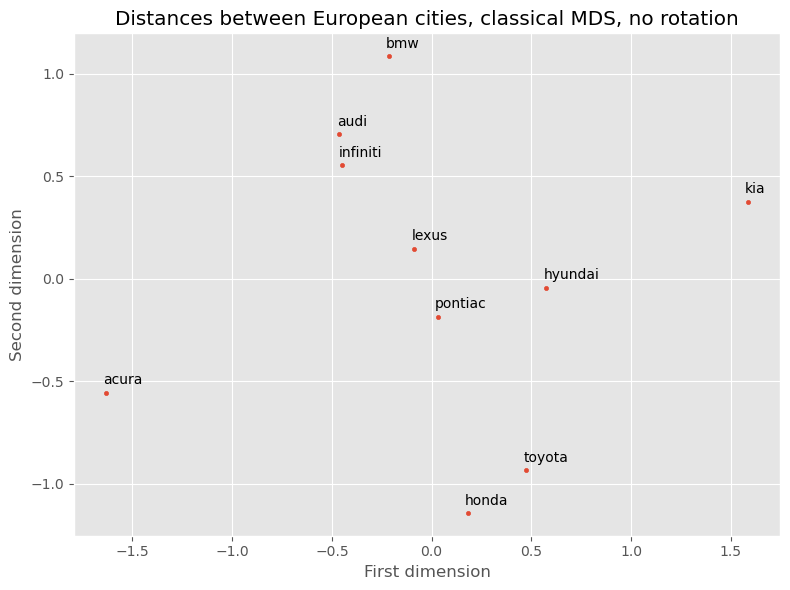

In [244]:
# Get lift matrix
df = pd.read_csv('data/Lift_Matrix.csv', index_col = 0)
# # replace 0 with NaN
# df.replace(0, np.nan, inplace=True)
# # Replace diagonal with 0
# np.fill_diagonal(df.values, 0)
# invert lift values
df_transformed = df.applymap(lambda x: 1/x if x != 0 else x)
# get MDS points
X = cMDS(df_transformed, 2)
# plot
plot(X, df_transformed.columns.values, algorithm = 'classical MDS, no rotation')

## Task E: Insights from C and D

## Task F: Car Attributes
Some car attributes that occurred frequently in messages are:
1. performance
2. luxury
3. price
4. seat
5. interior

In [ ]:
# calculate lift for each of these words with the 10 brands above


## Task G: Advice from F

## Task H: Aspirational Brands

In [ ]:
# include aspirational bigrams and trigrams at the bottom of "car_models_and_brands.csv" to replace with "aspiration" in task B

# calculate lift between each brand and aspiration